# Rekurencyjne sieci neuronowe (RNN)

## Metoda gorącej jedynki

Kodowanie słów:

In [1]:
import numpy as np

# Początkowa forma danych: jeden element na próbkę
# # (w tym przykładzie próbką jest zdanie, ale może ona być również całym dokumentem)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Zbuduj indeks wszystkich tokenów danych
token_index = {}
for sample in samples:
    # Tokenizacja próbek poprzez metodę podziału.
    # Podczas pracy z prawdziwymi danymi podziału dokonuje się również na znakach interpunkcyjnych i specjalnych
    for word in sample.split():
        if word not in token_index:
            # Przypisywanie unikatowego indeksu do każdego unikatowego słowa.
            token_index[word] = len(token_index) + 1
            # Zwróć uwagę na to, że indeks 0 nie jest przypisywany do żadnego słowa

# Wektoryzacja próbek. Bierzemy pod uwagę tylko max_length pierwszych słów każdej próbki.
max_length = 10
# Tu przechowujemy wyniki operacji:
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

Kodowanie znaków:

In [2]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable   # Wszystkie znaki ASCII, które można wyświetlić
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

Kodowanie metofą gorącej jedynki przy użyciu gotowych narzędzi pakietu Keras:

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Tworzy mechanizm tokenizacji skonfigurowany tak,
# aby brał pod uwagę tylko 1000 najczęściej występujących słów
tokenizer = Tokenizer(num_words=1000)
# Buduje indeks słów.
tokenizer.fit_on_texts(samples)

# Zamienia łańcuchy na listy indeksów (wartości całkowitoliczbowe)
sequences = tokenizer.texts_to_sequences(samples)

# Możliwe jest również uzyskanie bezpośredniej binarnej reprezentacji kodowania metodą gorącej jedynki.
# Ten generator tokenów obsługuje także inne tryby wektoryzacji.
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# Przykład kodu pozwalającego na uzyskanie dostępu do indeksu słów.
word_index = tokenizer.word_index
print('Znaleziono %s unikatowych tokenów.' % len(word_index))

Znaleziono 9 unikatowych tokenów.


## *One-hot hashing trick:

In [5]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Słowa są zapisywane w postaci wektorów o długości 1000.
# Jeżeli przetworzymy przykład, w którym znajduje się około 1000 różnych słów,
# to zauważymy wiele konfliktów haszy,
# które doprowadzą do pogorszenia dokładności tej metody kodowania.
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # Słowom przypisywane są losowe wartości całkowite indeksu z zakresu od 0 do 1000.
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## Word embeddings

In [1]:
from keras.layers import Embedding

# Warstwa Embedding przyjmuje przynajmniej dwa argumenty:
# liczbę tokenów (tutaj 1000: 1 + maksymalny indeks słowa)
# i liczbę wymiarów osadzeń (tutaj 64).
embedding_layer = Embedding(1000, 64)

In [2]:
from keras.datasets import imdb
from keras import preprocessing

# Liczba słów analizowanych w charakterze wag.
max_features = 10000
# Ucina recenzje, w których występuje ta liczba słów
# (słów zaliczanych do zbioru max_features najczęściej występujących słów).
maxlen = 20

# Ładuje dane w formie list wartości całkowitoliczbowych.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Zamieniamy listy liczb całkowitych na dwuwymiarowy tensor
# wartości całkowitoliczbowych o kształcie (próbki, maxlen).
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# Określamy maksymalną długość danych wejściowych warstwy Embedding,
# co umożliwi późniejsze spłaszczenie osadzonych danych wejściowych.
model.add(Embedding(10000, 8, input_length=maxlen))
# Po przetworzeniu przez warstwę osadzania aktywacje mają kształt (próbki, maxlen, 8).

# Spłaszczanie trójwymiarowego tensora osadzeń
# w celu uzyskania dwuwymiarowego tensora o kształcie (próbki, maxlen * 8).
model.add(Flatten())

# Dodawanie ostatniej warstwy klasyfikatora.
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.5574 - loss: 0.6863 - val_acc: 0.6874 - val_loss: 0.6243
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - acc: 0.7423 - loss: 0.5740 - val_acc: 0.7276 - val_loss: 0.5309
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - acc: 0.7892 - loss: 0.4708 - val_acc: 0.7440 - val_loss: 0.5032
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - acc: 0.8122 - loss: 0.4256 - val_acc: 0.7500 - val_loss: 0.4966
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - acc: 0.8226 - loss: 0.3973 - val_acc: 0.7544 - val_loss: 0.4962
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - acc: 0.8422 - loss: 0.3686 - val_acc: 0.7526 - val_loss: 0.4985
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - acc: 0.8523 - loss: 0.3480 - val_acc: 0.7528 - val_loss: 0.5038
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - acc: 0.8598 - loss: 0.3361 - val_acc: 0.7514 - val_loss: 0.5104
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

## Rekurencyjne sieci neuronowe RNN

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))    # Ostatnia warstwa zwraca tylko ostatni obiekt wyjściowy
model.summary()

In [17]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000    # Liczba słów traktowanych jako cechy.
maxlen = 500    # Ucina recenzje po tej liczbie słów należących do zbioru max_features słów najczęściej występujących w zbiorze.
batch_size = 32

print('Ładowanie danych...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'sekwencje treningowe')
print(len(input_test), 'sekwencje testowe')

print('Sekwencje (próbki x czas)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('Kształt obiektu input_train:', input_train.shape)
print('Kształt obiektu input_test:', input_test.shape)

Ładowanie danych...
25000 sekwencje treningowe
25000 sekwencje testowe
Sekwencje (próbki x czas)
Kształt obiektu input_train: (25000, 500)
Kształt obiektu input_test: (25000, 500)


Przygotuj prostą architekturę z wykorzystaniem sieci RNN (z podanymi parametrami):

In [19]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

Kompilację sieci:

In [21]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 20, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,228 (2.46 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 322,115 (1.23 MB)

Trenowanie:

In [23]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6134 - loss: 0.6420 - val_accuracy: 0.7368 - val_loss: 0.5285
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7908 - loss: 0.4514 - val_accuracy: 0.7418 - val_loss: 0.5378
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8508 - loss: 0.3530 - val_accuracy: 0.7326 - val_loss: 0.5413
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2573 - val_accuracy: 0.7146 - val_loss: 0.6191
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9460 - loss: 0.1629 - val_accuracy: 0.7082 - val_loss: 0.7211
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9709 - loss: 0.0933 - val_accuracy: 0.7064 - val_loss: 0.8612
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9866 - loss: 0.0507 - val_accuracy: 0.7100 - val_loss: 1.0033
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9931 - loss: 0.0267 - val_accuracy: 0.

Przygotuj i wyświetl wykresy dokładności i straty w procesach trenowania i walidacji:

In [24]:
from matplotlib import pyplot as plt

def plot_history(history_dict):
  training_loss = history_dict['loss']
  validation_loss = history_dict['val_loss']

  training_accuracy = history_dict['accuracy']
  validation_accuracy = history_dict['val_accuracy']

  plt.figure(figsize = (12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(training_loss)
  plt.plot(validation_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(training_accuracy)
  plt.plot(validation_accuracy)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

  plt.tight_layout()
  plt.show()

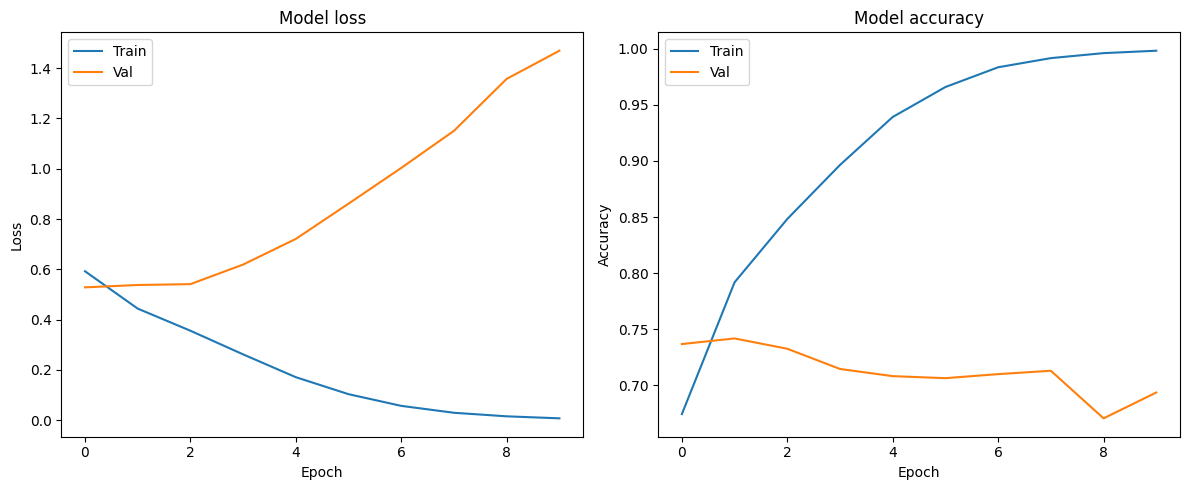

In [25]:
history_dict = history.history

plot_history(history_dict)

Model z większą liczbą warstw SimpleRNN(32):

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4991 - loss: 0.7094 - val_accuracy: 0.5104 - val_loss: 0.7131
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5430 - loss: 0.6875 - val_accuracy: 0.6654 - val_loss: 0.6164
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7223 - loss: 0.5566 - val_accuracy: 0.7304 - val_loss: 0.5337
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7987 - loss: 0.4452 - val_accuracy: 0.7114 - val_loss: 0.5476
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8346 - loss: 0.3783 - val_accuracy: 0.7270 - val_loss: 0.5301
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8783 - loss: 0.3071 - val_accuracy: 0.7358 - val_loss: 0.6337
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9031 - loss: 0.2457 - val_accuracy: 0.7008 - val_loss: 0.6601
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9345 - loss: 0.1796 - val_acc

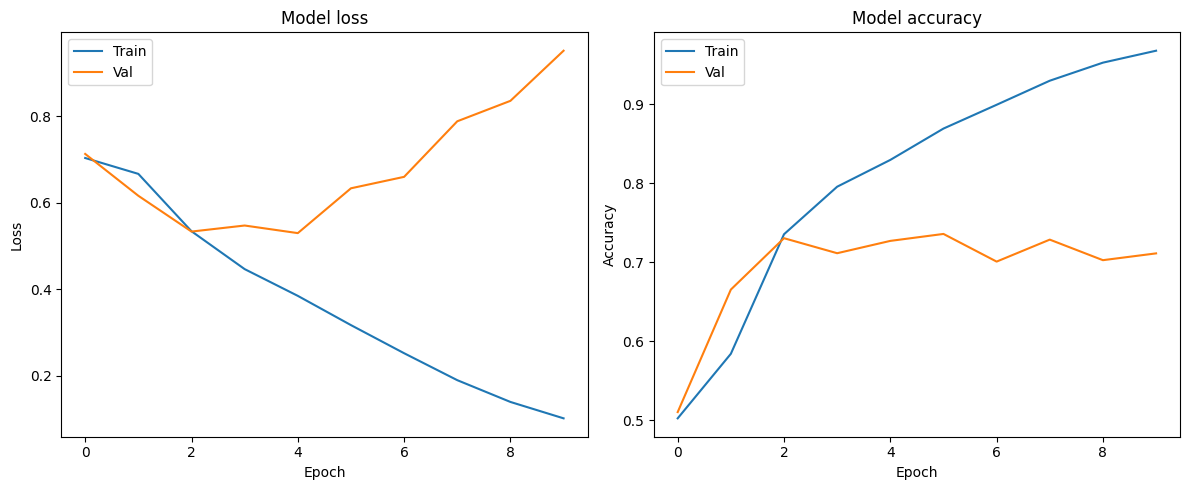

In [40]:
model2 = Sequential()
model2.add(Embedding(10000, 32))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))


model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history2 = model2.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


history2_dict = history2.history

plot_history(history2_dict)